**For tqdm progress bar to work correctly, before launching this notebook run:**
```bash
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

**Also for GIF to appear launch jupyter as follows:**
```bash
$ jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

**Or simply run from project root:**
```bash
$ make jupyter
```
### imports

In [22]:
import numpy as np
import tensorflow as tf; tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from JSAnimation.IPython_display import display_animation

import env
from hdm.dbm import DBM
from hdm.rbm import BernoulliRBM
from hdm.utils import (progress_bar, Stopwatch, RNG, 
                       im_plot, im_reshape, im_gif, tick_params,
                       plot_confusion_matrix)
from hdm.utils.dataset import load_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load trained RBM #1

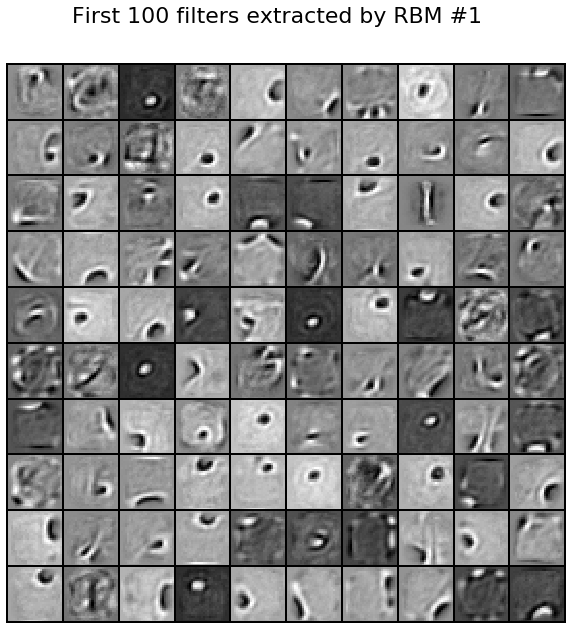

In [2]:
rbm1 = BernoulliRBM.load_model('../models/dbm_mnist_rbm1/')

rbm1_W = rbm1.get_tf_params(scope='weights')['W']
fig = plt.figure(figsize=(10, 10))
im_plot(rbm1_W.T, shape=(28, 28), title='First 100 filters extracted by RBM #1',
        imshow_params={'cmap': plt.cm.gray});
plt.savefig('dbm_mnist_rbm1.png', dpi=196);

## load trained RBM #2 on extracted features $\mathbf{q}_i=p(\mathbf{h}\;|\;\mathbf{v}=\mathbf{x}_i)$ from RBM #1

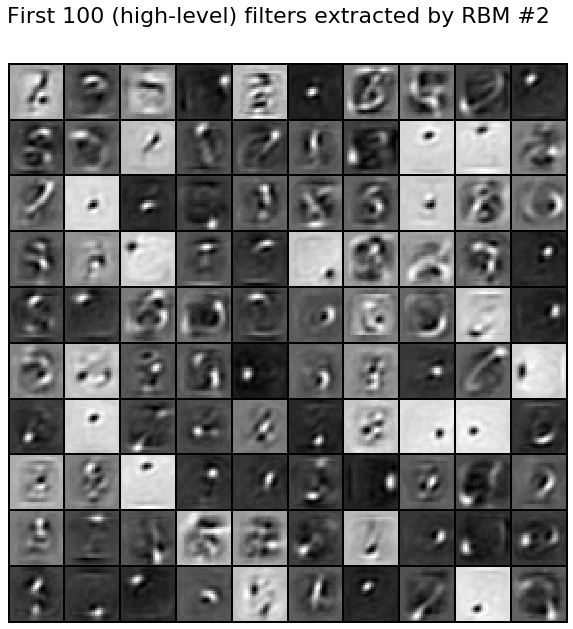

In [3]:
rbm2 = BernoulliRBM.load_model('../models/dbm_mnist_rbm2/')

rbm2_W = rbm2.get_tf_params(scope='weights')['W']
U = rbm1_W.dot(rbm2_W)

fig = plt.figure(figsize=(10, 10))
im_plot(U.T, shape=(28, 28), title='First 100 (high-level) filters extracted by RBM #2',
        imshow_params={'cmap': plt.cm.gray});
plt.savefig('dbm_mnist_rbm2.png', dpi=196);

## load trained DBM and visualize filters in layers 1 and 2

In [4]:
dbm = DBM.load_model('../models/dbm_mnist/')
dbm.load_rbms([rbm1, rbm2]) # !!!

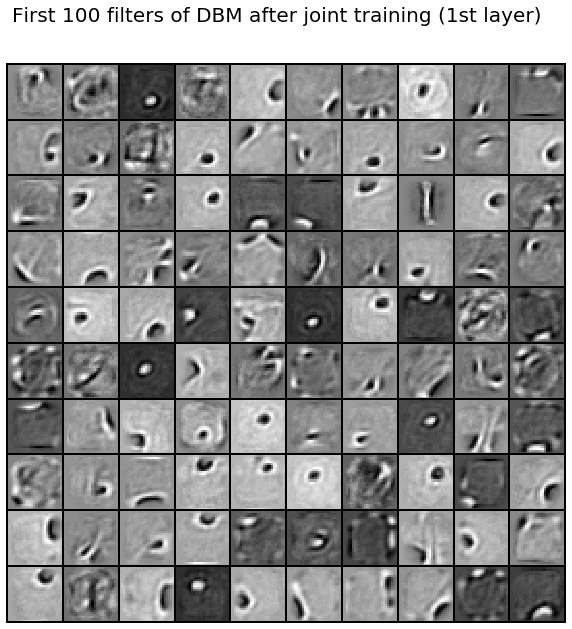

In [5]:
W1_joint = dbm.get_tf_params(scope='weights')['W']

fig = plt.figure(figsize=(10, 10))
im_plot(W1_joint.T, shape=(28, 28), title='First 100 filters of DBM after joint training (1st layer)',
        title_params={'fontsize': 20}, imshow_params={'cmap': plt.cm.gray});
plt.savefig('dbm_mnist_W1_joint.png', dpi=196);

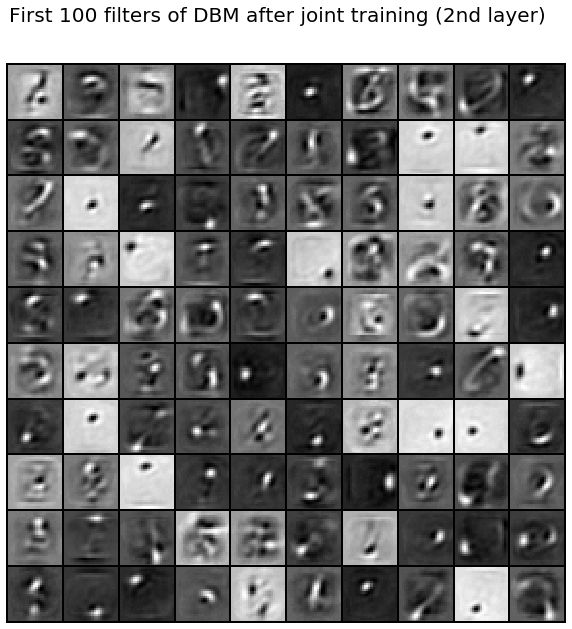

In [6]:
W2_joint = dbm.get_tf_params(scope='weights')['W_1']
U_joint = W1_joint.dot(W2_joint)

fig = plt.figure(figsize=(10, 10))
im_plot(U_joint.T, shape=(28, 28), title='First 100 filters of DBM after joint training (2nd layer)',
        title_params={'fontsize': 20}, imshow_params={'cmap': plt.cm.gray});
plt.savefig('dbm_mnist_W2_joint.png', dpi=196);

## load MNIST

In [7]:
X, y = load_mnist(mode='train', path='../data/')
X /= 255.
X_test, y_test = load_mnist(mode='test', path='../data/')
X_test /= 255.
print X.shape, y.shape, X_test.shape, y_test.shape

(60000, 784) (60000,) (10000, 784) (10000,)


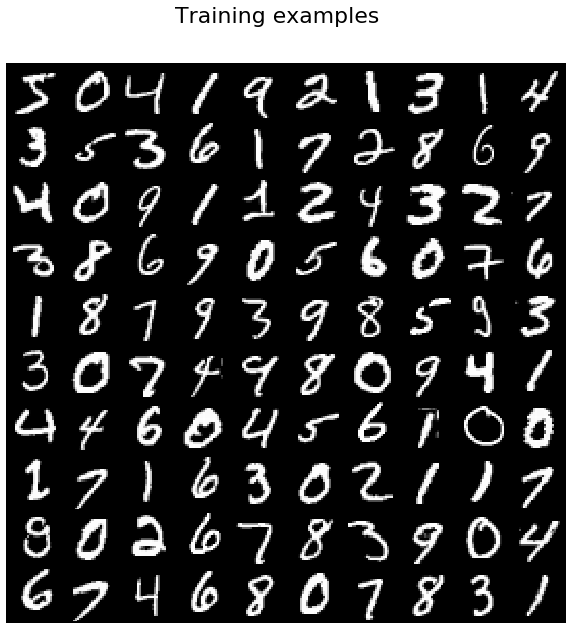

In [8]:
fig = plt.figure(figsize=(10, 10))
im_plot(X[:100], shape=(28, 28), title='Training examples', 
        imshow_params={'cmap': plt.cm.gray})
plt.savefig('mnist.png', dpi=196)

# generate samples (negative particles) after DBM training
## sample right after training

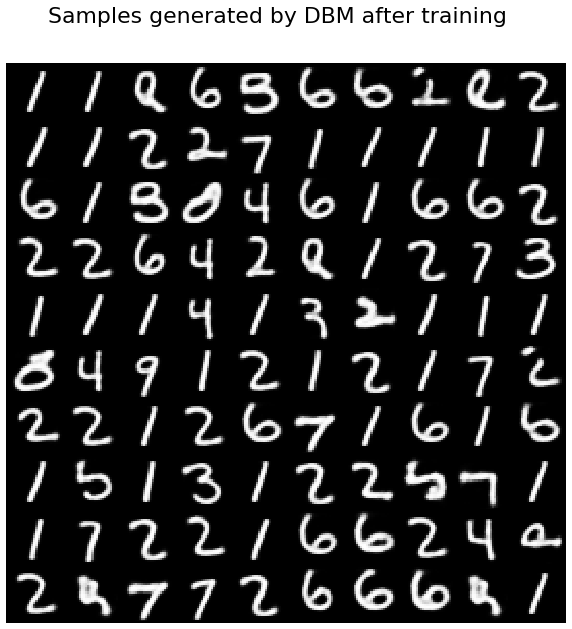

In [9]:
V = dbm.sample_v()

fig = plt.figure(figsize=(10, 10))
im_plot(V, shape=(28, 28), title='Samples generated by DBM after training',
        imshow_params={'cmap': plt.cm.gray});
plt.savefig('dbm_mnist_samples.png', dpi=196);

## generate more samples
**(Note that new samples override old particles on disk)**

In [10]:
samples = []
for i in progress_bar(range(25)):
    V = dbm.sample_v(n_gibbs_steps=100, save_model=True)
    Z = im_reshape(V, shape=(28, 28))
    samples.append(Z)

A Jupyter Widget

## make an animation and save to disk


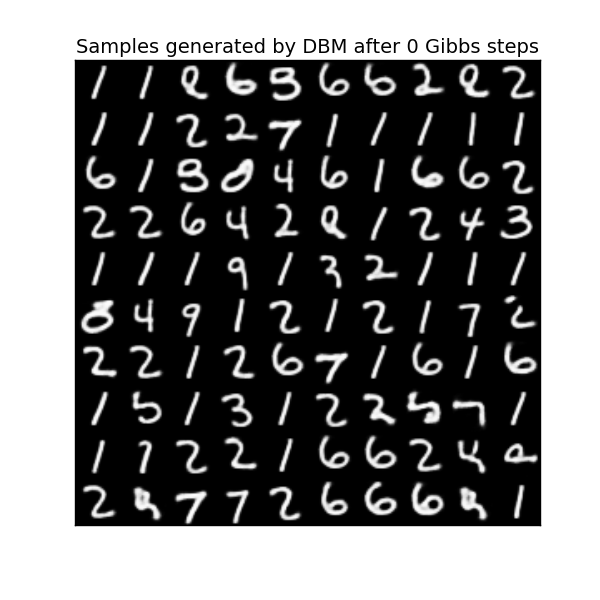
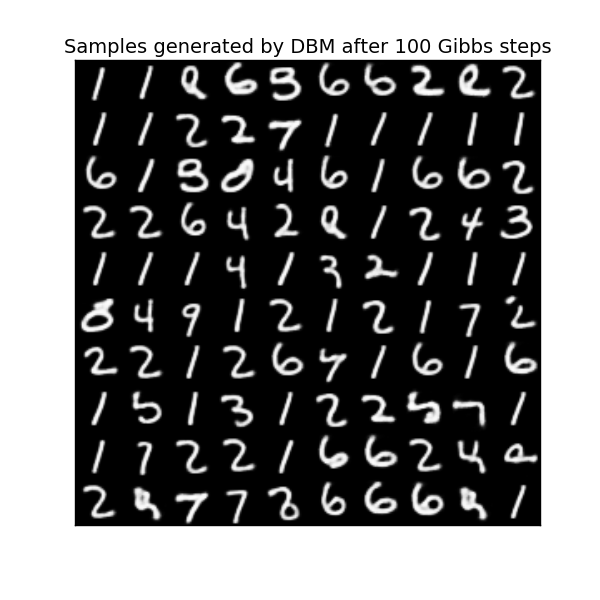
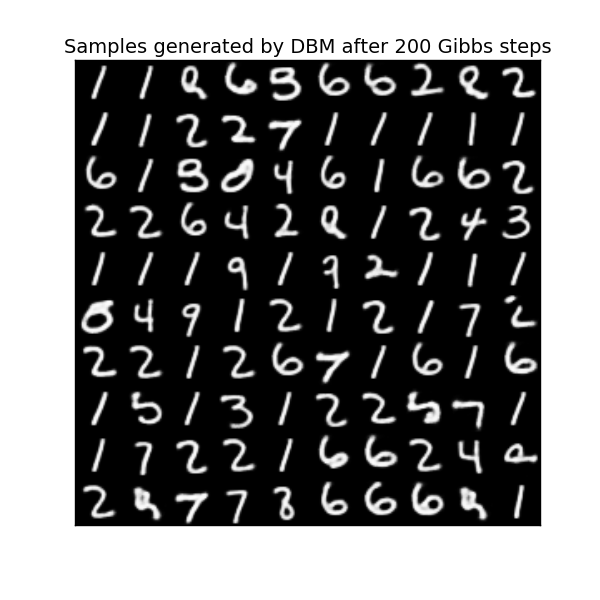
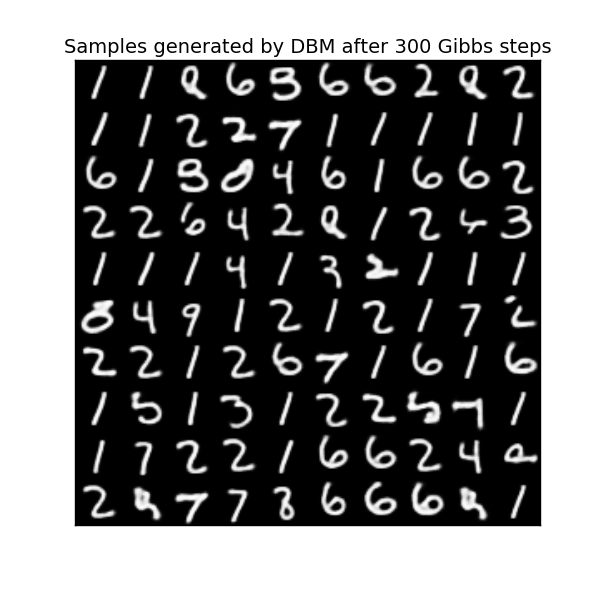
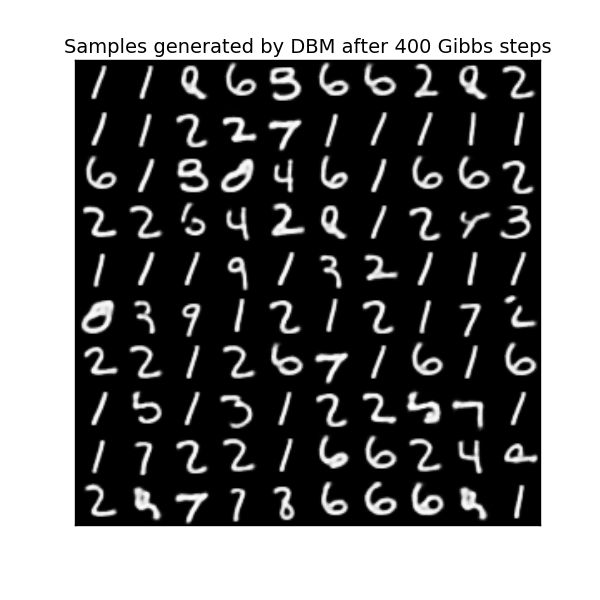
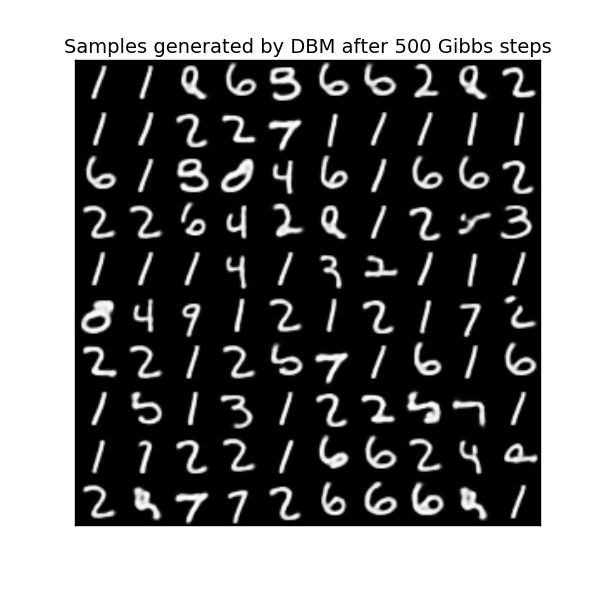
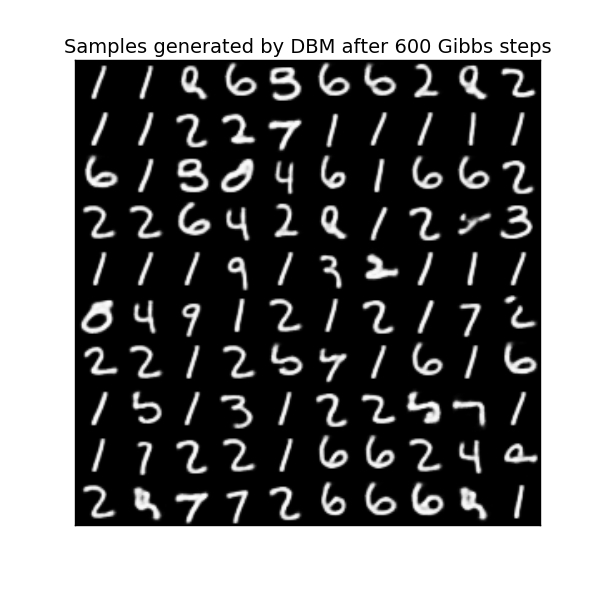
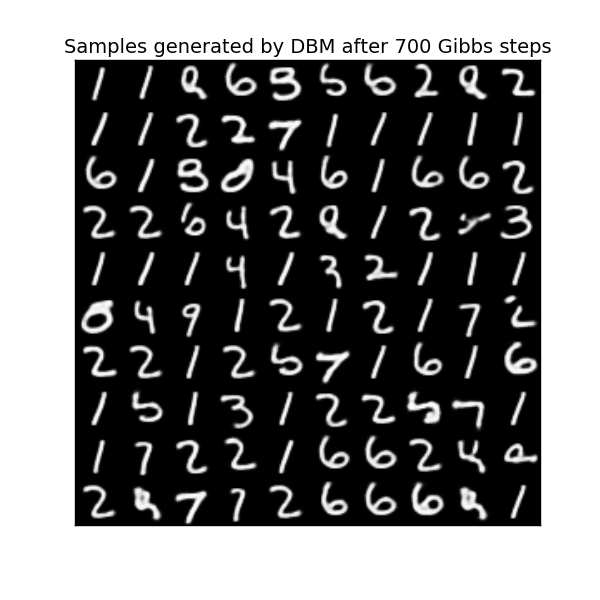
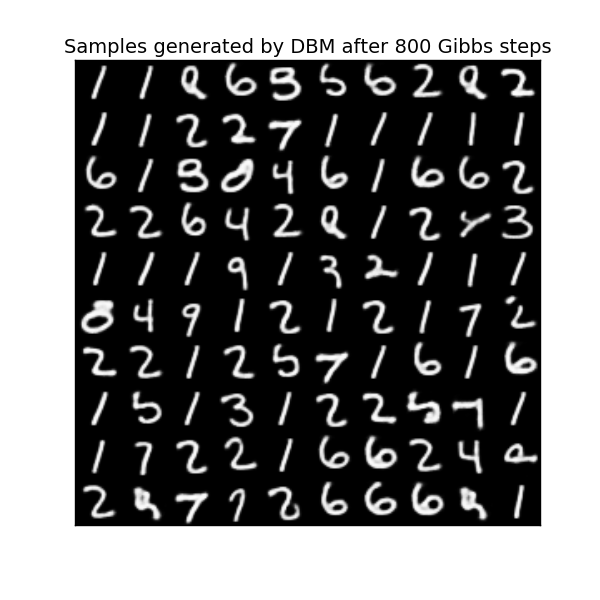
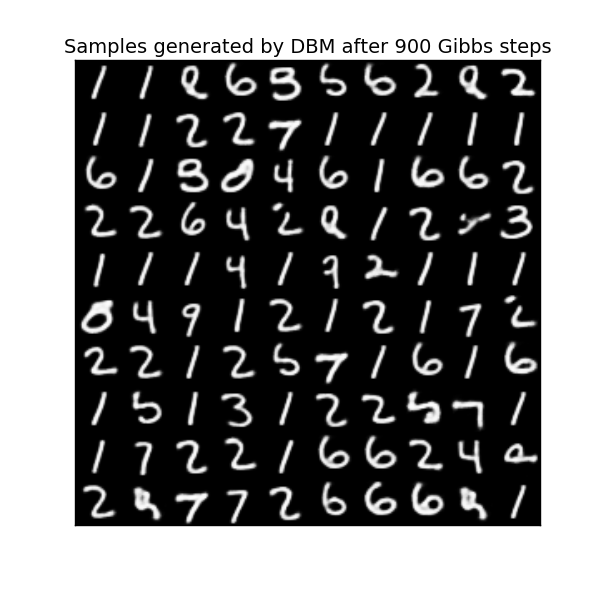
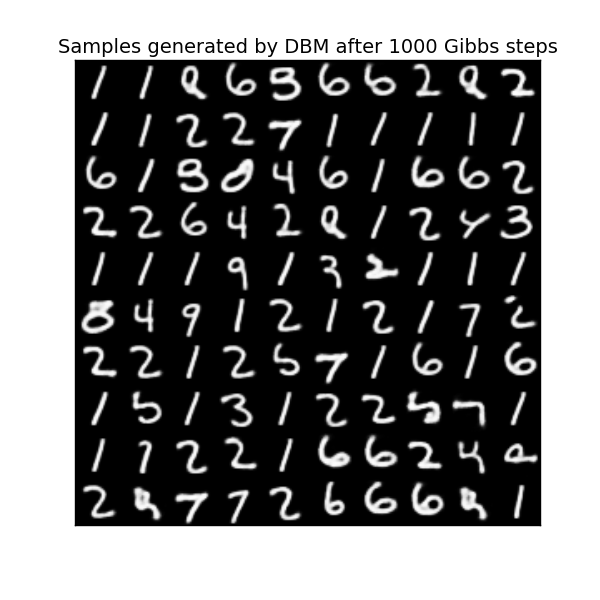
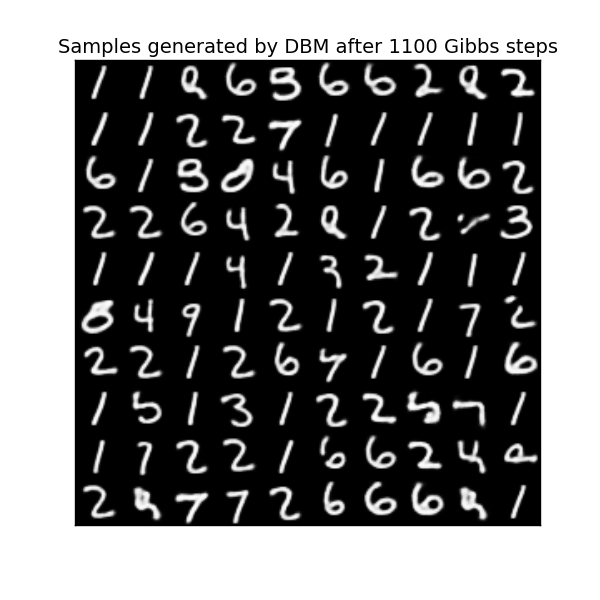
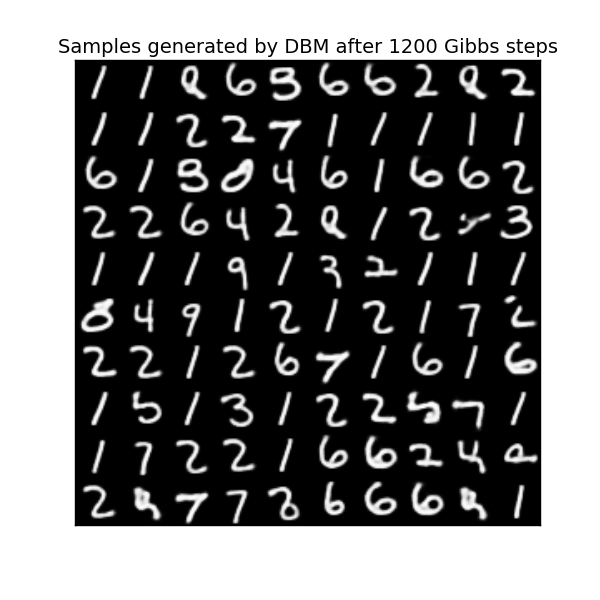
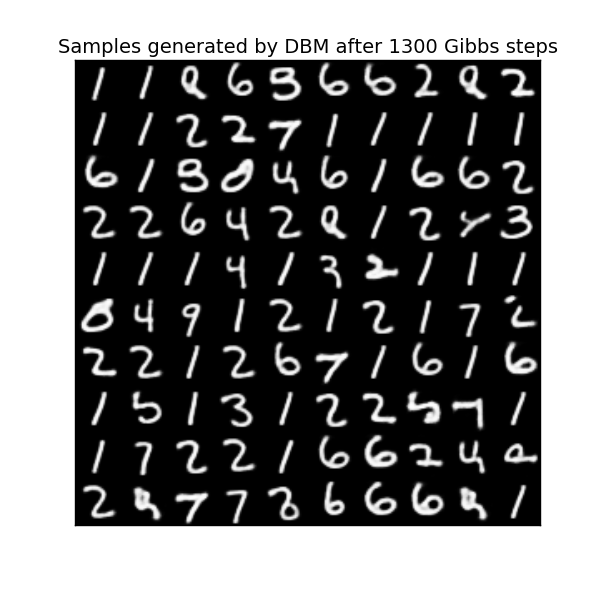
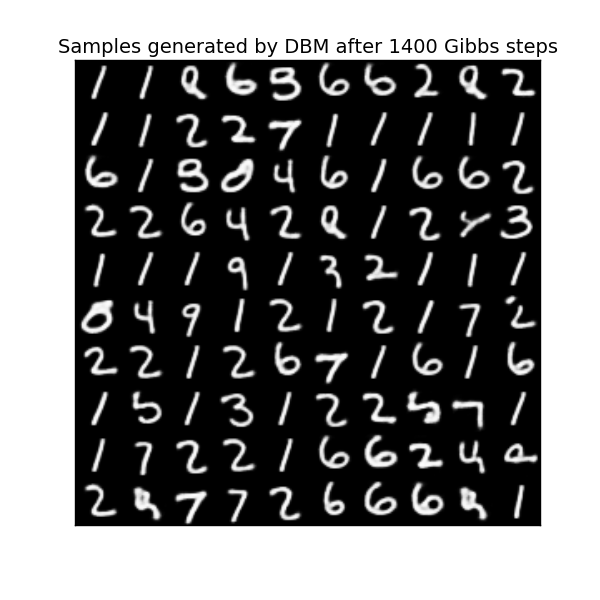
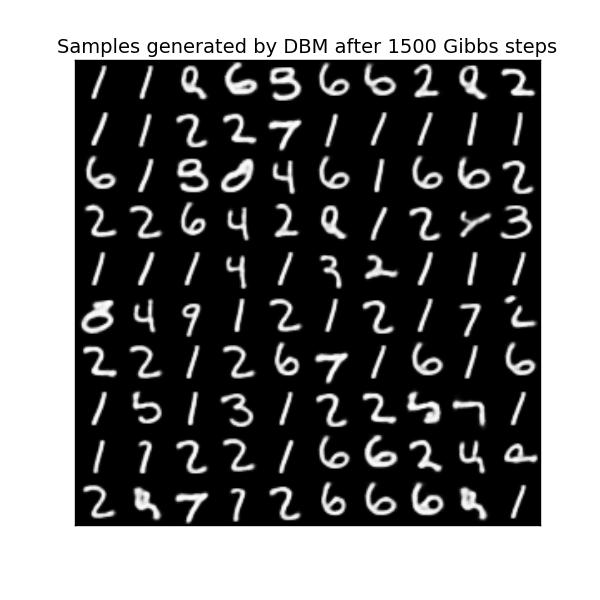
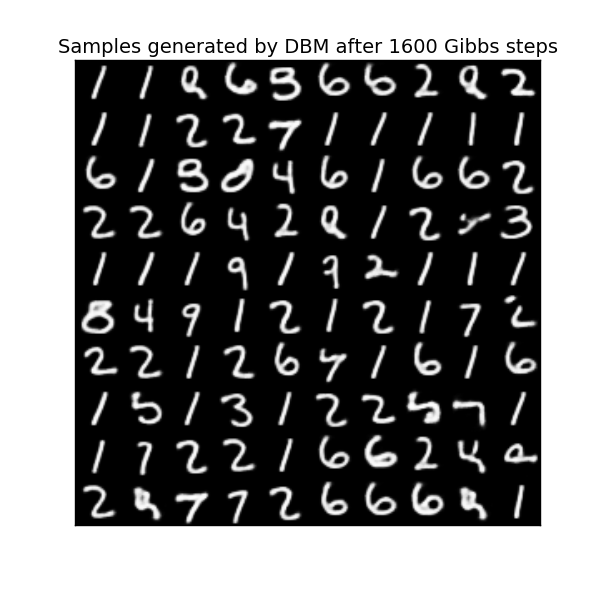
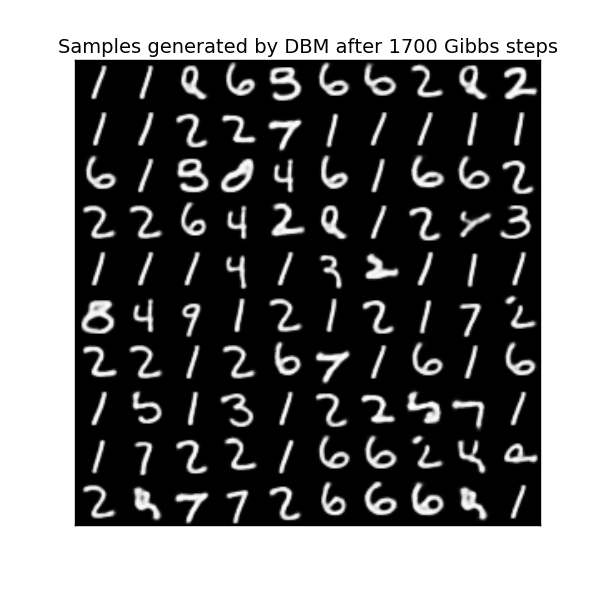
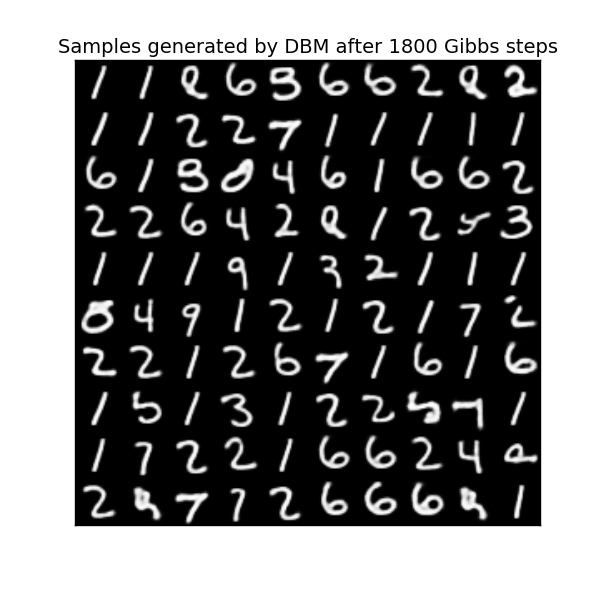
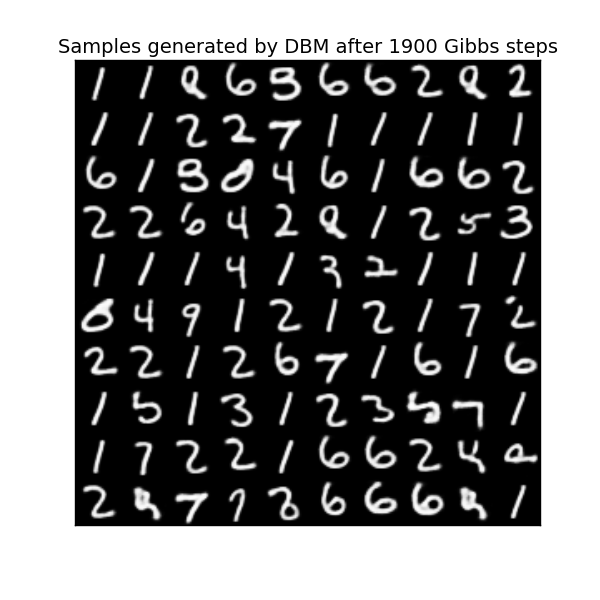
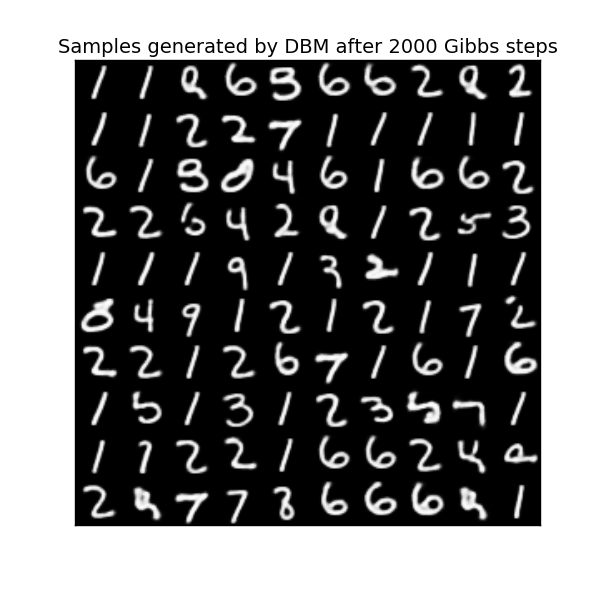
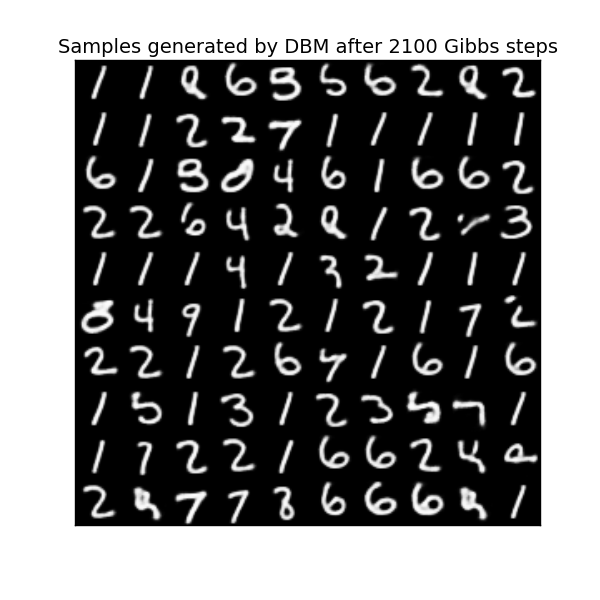
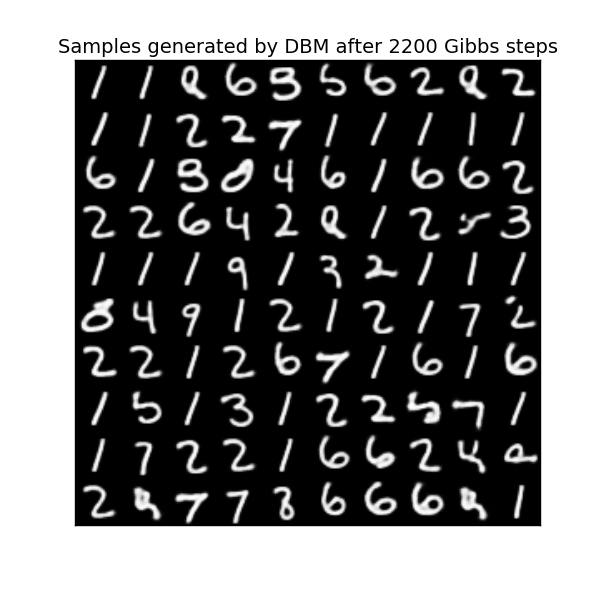
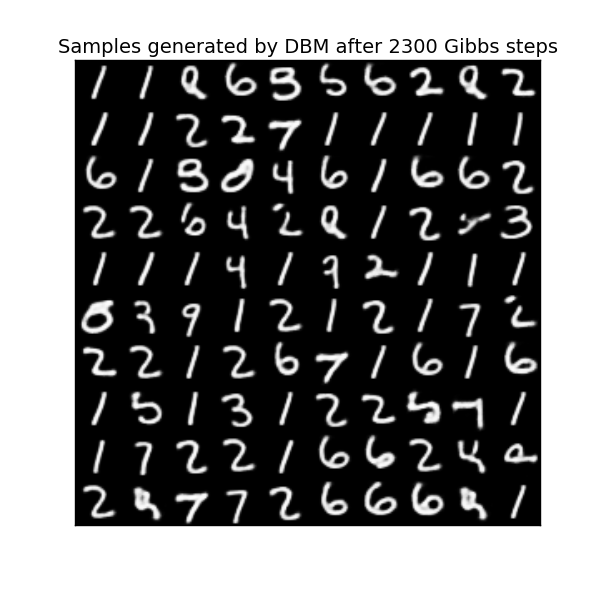
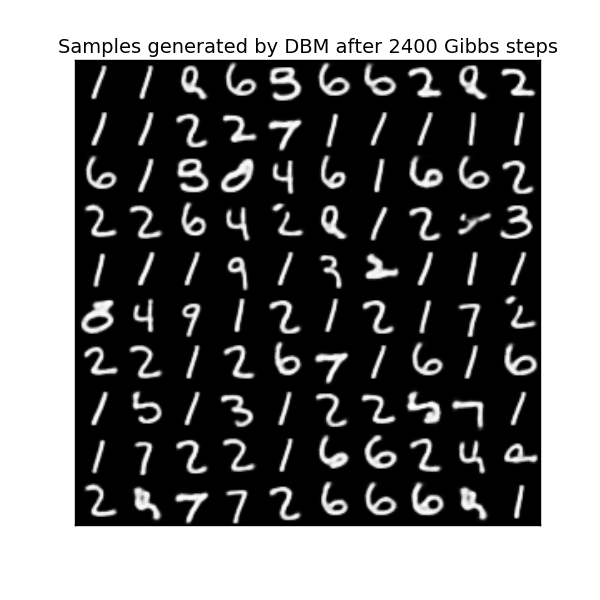

In [11]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(np.zeros((280, 280)), cmap=plt.cm.gray, animated=True, vmin=0., vmax=1.)
im.axes.tick_params(**tick_params())

anim = im_gif(samples, im, fig, fname='dbm_samples.gif',
              title_func=lambda i: 'Samples generated by DBM after {0} Gibbs steps'.format(100 * i),
              title_params={'fontsize': 14}, save_params={'dpi': 144})

display_animation(anim)

# estimate log partition function

In [39]:
with Stopwatch(verbose=True) as s:
    log_Z_mean, (log_Z_low, log_Z_high), log_Z_values = dbm.log_Z(n_runs=100, n_betas=20000, n_gibbs_steps=5)

Elapsed time: 1737.253 sec


### All estimates $\left(\widehat{\log{\mathcal{Z}}}_k\right)_{k=1:\mathbf{\text{n_runs}}}$

In [40]:
log_Z_values.shape

(100,)

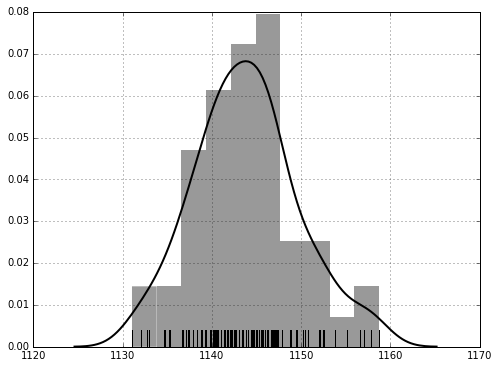

In [41]:
fig = plt.figure(figsize=(8, 6))
plt.grid()
sns.distplot(log_Z_values, rug=True, color='k', kde_kws={'lw': 2}, hist_kws={'lw': 0});

### $\log{\overline{\mathcal{Z}}}$

In [42]:
print "{:.2f}".format( log_Z_mean )

1154.68


### Note this is not the same as $\overline{\log{\mathcal{Z}}}$, which is

In [43]:
print "{:.2f}".format( np.mean(log_Z_values) )

1143.83


### $\log\left(\overline{\mathcal{Z}}-\sigma_{\mathcal{Z}}\right)$, $\log\left(\overline{\mathcal{Z}}+\sigma_{\mathcal{Z}}\right)$

In [44]:
print "{0:.2f}, {1:.2f}".format( log_Z_low, log_Z_high )

nan, 1156.65


### `nan` simply means that $\log\sigma_{\mathcal{Z}}>\log\overline{\mathcal{Z}}$, which is not rare, and again, it is not the same as $\sigma\left(\log{\mathcal{Z}}\right)$, which is

In [45]:
print "{:.2f}".format( np.std(log_Z_values) )

5.77


# average log-probability (lower-bound) on the test set: 
### \begin{align*}
\log p(\mathbf{v}^{*};\boldsymbol{\psi})\geq\;&-\sum_{\mathbf{h}} q(\mathbf{h};\boldsymbol{\mu})E(\mathbf{v}^{*}, \mathbf{h};\boldsymbol{\psi})+\mathcal{H}(\boldsymbol{\mu})-\log\mathcal{Z}(\boldsymbol{\psi})
\\
=\;& \mathbf{v}^{*^{T}}\mathbf{W}^{(1)}\boldsymbol{\mu}^{(1)}+\boldsymbol{\mu}^{(1)^{T}}\mathbf{W}^{(2)}\boldsymbol{\mu}^{(2)}+\mathbf{b}\cdot\mathbf{v}^{*}+\mathbf{c}^{(1)}\cdot\boldsymbol{\mu}^{(1)}+\mathbf{c}^{(2)}\cdot\boldsymbol{\mu}^{(2)}+\mathcal{H}(\boldsymbol{\mu})-\log\mathcal{Z}(\boldsymbol{\psi})
\\
\approx\;& \mathbf{v}^{*^{T}}\mathbf{W}^{(1)}\boldsymbol{\mu}^{(1)}+\boldsymbol{\mu}^{(1)^{T}}\mathbf{W}^{(2)}\boldsymbol{\mu}^{(2)}+\mathbf{b}\cdot\mathbf{v}^{*}+\mathbf{c}^{(1)}\cdot\boldsymbol{\mu}^{(1)}+\mathbf{c}^{(2)}\cdot\boldsymbol{\mu}^{(2)}+\mathcal{H}(\boldsymbol{\mu})-\log\widehat{\mathcal{Z}}
\end{align*}

In [46]:
log_p = dbm.log_proba(X_test, log_Z=log_Z_mean)

A Jupyter Widget

In [47]:
print "{:.2f}".format( log_p.mean() )

-67.28


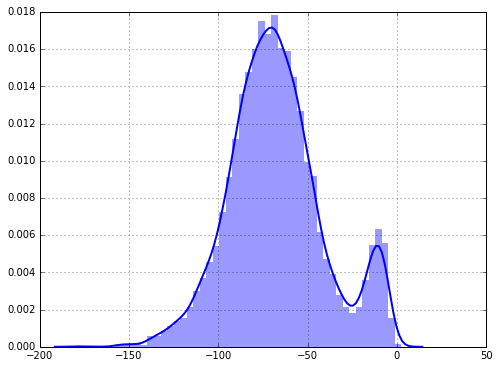

In [50]:
fig = plt.figure(figsize=(8, 6))
plt.grid()
sns.distplot(log_p, color='b', kde_kws={'lw': 2}, hist_kws={'lw': 0});

# discriminative fine-tuning